## Black vs. grey box modeling: generalization capabilities

In this notebook we will investigate the generalization behavior of black and grey box models. To do so, we will re-utilize the previous [DC-motor temperature example](Hammerstein_Temperature_Motor.ipynb) using a Hammerstein ground truth model:
$$\frac{\mathrm{d}}{\mathrm{d}t}x(t) = \frac{1}{C_\mathrm{Th}}\left(\frac{\vartheta_\mathrm{A}(t)-x(t)}{R_\mathrm{Th}} + P_\mathrm{v}(u(t), x(t))\right).$$

Based on this, we will compare
- a grey box NODE model which utilizes some a priori system knowledge and
- a black box model based on a general nonlinear discrete-time state-space model.

In particular we are interested in fitting the models with a certain data scope and then study the model inference within new operation conditions, that is, their generalization capabilities. 

In [1]:
using OrdinaryDiffEq, Lux, Random, ComponentArrays, Plots, BenchmarkTools, StatsBase, LaTeXStrings, Statistics
using Parameters: @unpack
using SciMLSensitivity, Optimization, Zygote, OptimizationFlux, LinearAlgebra

We start with generating some training data:

In [ ]:
function simple_motor_temperature_model(dx, x, p, t)
    i(t)    = p[1](t); # motor current (time-dependent function)
    n(t)    = p[2](t); # motor speed (time-dependent function)
    ϑ_A(t)  = p[3](t); # ambient temperature (time-dependent function)
    R_Cu(t) = p[4] * (1 + p[5] * (x[1] - 20)) # copper resistance (temperature dependent with room temperature as reference)
    R_Fe(t) = p[6] * (1 + p[7] * (x[1] - 20)) # iron resistance (temperature dependent with room temperature as reference)
    L       = p[8] # inductance

    Pv(t)  = i(t)^2 * R_Cu(t) + (L * i(t) * n(t)/60*2*pi)^2 / R_Fe(t) # power loss in the motor
    
    dx[1]  = 1 / p[9] * ((-x[1] + ϑ_A(t)) / p[10] + Pv(t)) # temperature dynamics
end;

In [ ]:
i = t -> Float32(125 + 50*sin(2*pi*t/60) + 60*sin(2*pi*t/300)) # motor current (time-dependent function)
n = t -> Float32(1000 + 100*cos(2*pi*t/100) + 500*cos(2*pi*t/1000)) # motor speed (time-dependent function)
ϑ_A = t -> Float32(20 + 2*sin(2*pi*t/2000)) # ambient temperature (time-dependent function)
p_ODE = (i, n, ϑ_A, 0.016, 0.0039, 5000.0, 0.00651, 0.05, 1400.0, 0.17); # true parameters (tuple)

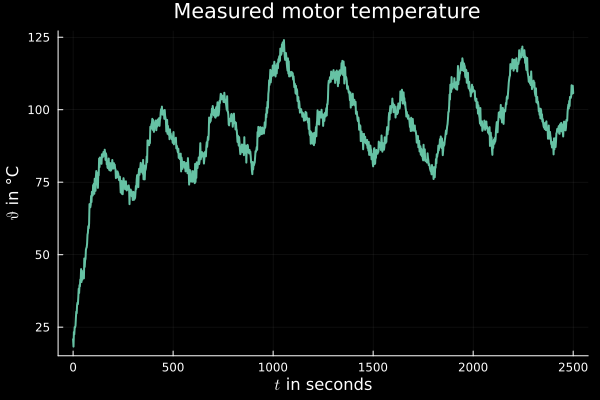

In [ ]:
x0 = [20]   # initial temperature
dt = 2.0f0  # sampling time
tspan = (0.0, 2500.0) # simulation time span

prob = ODEProblem(simple_motor_temperature_model, x0, tspan, p_ODE) # define ODE problem
sol = solve(prob, Tsit5(), saveat=dt); # solve ODE problem

t = sol.t # time vector 
x = reduce(vcat,sol.u) # temperature vector
y = x .+ 1.5*randn(size(x)); # measured temperature vector incl. additive noise  

# plot results
plot(t, y, title=" Measured motor temperature", xlabel=L"$t$ in seconds", ylabel=L"$\vartheta$ in °C", 
    background_color="#000000",lw=2, palette = :Set2_5, legend = false)

### Training of the black box model

As the **black box model** we utilize a nonlinear discrete-time state-space model in the form $$\hat{x}[k+1] = f_w(\hat{x}[k], u[k]), \quad x[0]=x_0$$ where $f_w(\ldots)$ is a feedforward artificial neural network (ANN) with the weights $w$. Given the sampled input data $u[k]$, this model describes the state transition from time step $k$ to $k+1$ without incorporating any a priori system knowledge, that is, we do not utilize any structural constraints on the model topology.    

Configure the training simulation framework:

In [ ]:
NF = Float32 
x0_NODE = [NF.(y[1])] # initial temperature
tspan_NODE = NF.(tspan) # simulation time span
datasize = Int(tspan_NODE[2]/dt+1) # number of data points
tsteps_NODE = range(tspan_NODE[1], tspan_NODE[2]; length=datasize); # time vector 

Obtain training data on a discrete-time grid and standardize the data. Due to the black box charakter of the model, this data pre-processing is of particular importance. 

In [ ]:
i_sqr_vec = map(x -> i(x).^2, tsteps_NODE) # squared current vector
ϑ_A_vec = map(x -> ϑ_A(x), tsteps_NODE); # ambient temperature vector
in_sqr_vec = map(x -> i(x).^2 .* n(x).^2, tsteps_NODE); # squared current times speed vector

tf_in_sqr_vec = fit(ZScoreTransform, in_sqr_vec) # fit Z-score transformation to squared current times speed vector
tf_i_sqr_vec = fit(ZScoreTransform, i_sqr_vec) # fit Z-score transformation to squared current vector
tf_ϑ_A_vec = fit(ZScoreTransform, ϑ_A_vec) # fit Z-score transformation to ambient temperature vector
tf_y = fit(ZScoreTransform, y) # fit Z-score transformation to measured temperature vector

in_sqr_vec_norm = NF.(StatsBase.transform(tf_in_sqr_vec, in_sqr_vec)) # normalized squared current times speed vector
i_sqr_vec_norm = NF.(StatsBase.transform(tf_i_sqr_vec, i_sqr_vec)) # normalized squared current vector
ϑ_A_vec_norm = NF.(StatsBase.transform(tf_ϑ_A_vec, ϑ_A_vec)); # normalized ambient temperature vector
y_norm = NF.(StatsBase.transform(tf_y, y)); # normalized measured temperature vector

y_mean = NF.(tf_y.mean[1]) # mean of measured temperature vector
y_scale = NF.(tf_y.scale[1]); # scale of measured temperature vector   

Next, we set up the right-hand side of the discrete-time state-space model by a simple, low-order ANN without any hidden layer. We utilize a `tan()` output layer activation to enable positive as well as negative changes of the standardized temperature state between two time steps. 

In [ ]:
rng = MersenneTwister(260787) # seeding random number generator
ann_DE = Lux.Chain(Lux.Dense(4, 20, tanh; init_weight=glorot_uniform(;gain = 0.05)), Lux.Dense(20, 1, tanh; init_weight=glorot_uniform(;gain = 0.05))); # define neural network architecture
w_DE, st_DE =Lux.setup(rng, ann_DE); # initialize neural network parameters and state
w_DE = ComponentArray(w_DE); # initial guess parameters for difference equation approach (ComponentArray)

Define the difference equation general configuration vector (auxiliary variables):

In [ ]:
p_DE = (y_norm, in_sqr_vec_norm, i_sqr_vec_norm, ϑ_A_vec_norm, y_mean, y_scale); 

For the loss function, we need to take care of defining it in a non-mutating fashion to enable algorithmic differentiation later on.

In [ ]:
function loss_diff_eq(w, p)
    y, in_sqr_vec_norm, i_sqr_vec_norm, ϑ_A_vec_norm, y_mean, y_scale = p
    x = y[1] # initial temperature
    loss = zero(eltype(params_diff)) # initialize loss function
    for ii = 2:length(y)
        x += ann_DE([in_sqr_vec_norm[ii-1]; i_sqr_vec_norm[ii-1]; ϑ_A_vec_norm[ii-1]; x], w, st_DE)[1][1] # difference equation approach
        loss += abs2(y[ii] - x) # loss function
    end
    return loss
end;

We utilize an independent prediction function for visual inspection of the results.

In [ ]:
function predict_diff_eq(w, p)
    y, _in_sqr, _i_sqr, _ϑ_A, y_mean, y_scale = p
    x_hat = zeros(eltype(w), length(y))
    x_hat[1] = y[1]
    for ii = 2:length(y)
        x_hat[ii] = x_hat[ii-1] + ann_DE([_in_sqr[ii-1]; _i_sqr[ii-1]; _ϑ_A[ii-1]; x_hat[ii-1]], w, st_DE)[1][1]
    end
    return x_hat
end;

Define the optimization problem to identify the parameters of the black-box model.

In [ ]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction(loss_diff_eq, adtype)
optprob = Optimization.OptimizationProblem(optf, w_DE, p_DE);

In [ ]:
losses = Float32[]
callback_online = function (p, l)
    push!(losses, l)
    if length(losses) % 5 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end;

Solve the optimization problem.

In [ ]:
res = Optimization.solve(optprob, Adam(0.001);   maxiters=1000, maxtime = 120.0, callback=callback_online);

Current loss after 5 iterations: 1386.8131
Current loss after 10 iterations: 1227.5586
Current loss after 15 iterations: 983.46796
Current loss after 20 iterations: 671.86017
Current loss after 25 iterations: 413.59796
Current loss after 30 iterations: 237.6258
Current loss after 35 iterations: 140.09935
Current loss after 40 iterations: 99.230316
Current loss after 45 iterations: 87.11461
Current loss after 50 iterations: 80.84054
Current loss after 55 iterations: 70.25809
Current loss after 60 iterations: 56.6523
Current loss after 65 iterations: 44.747204
Current loss after 70 iterations: 36.66616
Current loss after 75 iterations: 31.479136
Current loss after 80 iterations: 27.55777
Current loss after 85 iterations: 24.149504
Current loss after 90 iterations: 21.277618
Current loss after 95 iterations: 19.063244
Current loss after 100 iterations: 17.43175
Current loss after 105 iterations: 16.219122
Current loss after 110 iterations: 15.3057995
Current loss after 115 iterations: 14.

Plot the results based on the same training data.

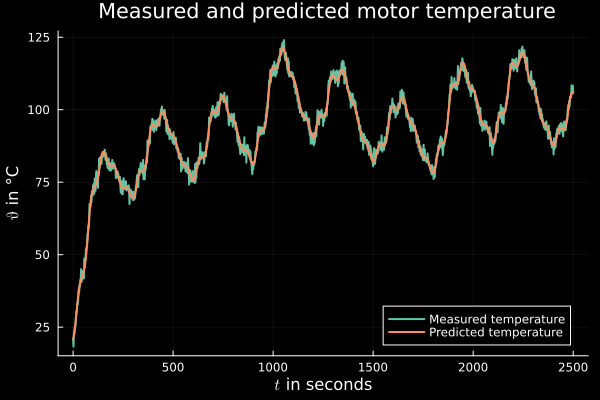

In [ ]:
plot(tsteps_NODE, y, title=" Measured and predicted motor temperature", 
    xlabel=L"$t$ in seconds", ylabel=L"$\vartheta$ in °C", background_color="#000000", 
    lw=2, palette = :Set2_5, label = "Measured temperature")
plot!(tsteps_NODE, StatsBase.reconstruct(tf_y, predict_diff_eq(res.u, p_DE)), label="Predicted temperature", lw=2)

Obviously, the training performance of the found model is very appealing as we achieve a very high prediction accuarcy. 

### Training of the grey box model

For the grey box model we re-utilize the Hammerstein-inspired NODE $$\frac{\mathrm{d}}{\mathrm{d}t}\hat{x}(t)= \frac{1}{\hat{C}_\mathrm{Th}}\left(\frac{\vartheta_\mathrm{A}(t)-x(t)}{\hat{R}_\mathrm{Th}} + \hat{P}_{\mathrm{v}, w_{\mathrm{NODE}}}(u(t))\right).$$

In [ ]:
ann_NODE = Lux.Chain(Lux.Dense(3, 10, tanh), Lux.Dense(10, 1, sigmoid)); # define neural network architecture
w_NODE, st_NODE =Lux.setup(rng, ann_NODE); # initialize neural network parameters and state
w_NODE = ComponentArray(w_NODE); # initial guess parameters for difference equation approach (ComponentArray)

### Generalization of the two models towards unseen data

In [ ]:
i_low = t -> Float32(50 + 50*sin(2*pi*t/60) + 60*sin(2*pi*t/300)) # motor current (time-dependent function)
p_ODE = (i_low, n, ϑ_A, 0.016, 0.0039, 5000.0, 0.00651, 0.05, 1400.0, 0.17); # true parameters (tuple)

In [ ]:
_prob = remake(prob, p = p_ODE) # define ODE problem
_sol = solve(_prob, Tsit5(), saveat=dt); # solve ODE problem

In [ ]:
i_low_sqr_vec = map(x -> i_low(x).^2, tsteps_NODE)
in_low_sqr_vec = map(x -> i_low(x).^2 .* n(x).^2, tsteps_NODE);

in_low_sqr_vec_norm = NF.(StatsBase.transform(tf_in_sqr_vec, in_low_sqr_vec))
i_low_sqr_vec_norm = NF.(StatsBase.transform(tf_i_sqr_vec, i_low_sqr_vec));

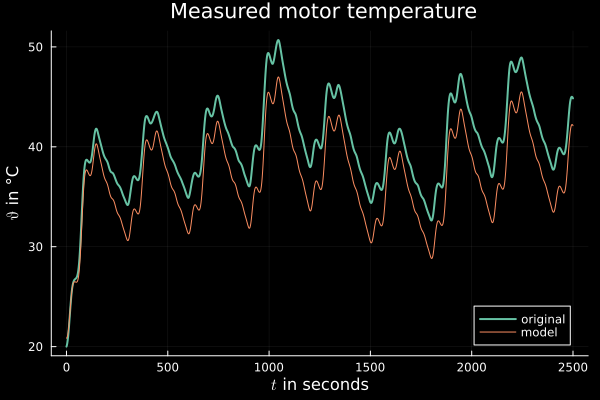

In [ ]:
# plot results
plot(_sol.t, reduce(vcat,_sol.u), title=" Measured motor temperature", xlabel=L"$t$ in seconds", ylabel=L"$\vartheta$ in °C", 
    background_color="#000000",lw=2, palette = :Set2_5, label = "original")
plot!(tsteps_NODE, StatsBase.reconstruct(tf_y, predict_diff_eq(res.u, (y_norm, in_low_sqr_vec_norm, i_low_sqr_vec_norm, ϑ_A_vec_norm, y_mean, y_scale))), label = "model")

In [ ]:
y_target[1]

LoadError: UndefVarError: y_target not defined